In [2]:
#Adding last modified date
from datetime import datetime
from IPython.display import display, Markdown
todays_date = str(datetime.now().date())
time = str(str(datetime.now().time()))
author = "Keerthana Arun"
display(Markdown(f'Last modified on {todays_date} at {time} by {author}'))

Last modified on 2024-06-21 at 18:16:45.305717 by Keerthana Arun

In [5]:
%conda install scvi-tools -c conda-forge

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: | ^C
failed with repodata from current_repodata.json, will retry with next repodata source.

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tempfile
import scanpy as sc
import scvi
import seaborn as sns
import torch

/home/mzo5929/.conda/envs/scvi-python-2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
naive = sc.read_10x_mtx("/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/count_SA2_078_naive/filtered_feature_bc_matrix")
gem = sc.read_10x_mtx("/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/count_SA2_078_Gem/filtered_feature_bc_matrix")
sot = sc.read_10x_mtx("/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/count_SA2_078_SotA/filtered_feature_bc_matrix")

In [7]:
naive.var_names_make_unique()
gem.var_names_make_unique()
sot.var_names_make_unique()

In [5]:
def countAnndata(adata):
    # Calculate the total counts per cell
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1  # Use .A1 to flatten the matrix if it's sparse
    # Calculate the number of genes per cell
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1).A1  # Change to > 0 to count genes with any expression
    # Calculate mitochondrial gene percentage, assuming gene names are in adata.var_names
    # and mitochondrial genes are prefixed with 'MT-'
    mt_gene_mask = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = adata[:, mt_gene_mask].X.sum(axis=1).A1 / adata.obs['n_counts'] * 100
    return adata

def qcAnndata(adata, min_counts=0, min_genes=0, max_mito_percentage=100, max_counts=float('inf'), max_genes=float('inf')):
    qc_mask = (
        (adata.obs['n_counts'] >= min_counts) &
        (adata.obs['n_counts'] <= max_counts) &
        (adata.obs['n_genes'] >= min_genes) &
        (adata.obs['n_genes'] <= max_genes) &
        (adata.obs['percent_mito'] <= max_mito_percentage)
    )
    # Filter the data
    return adata[qc_mask].copy()


In [6]:
naive = countAnndata(naive)
gem = countAnndata(gem)
sot = countAnndata(sot)
naiveQC = qcAnndata(naive, 7000, 2000, 10)
gemQC = qcAnndata(gem, 7000, 2000, 20)
sotQC = qcAnndata(sot, 7000, 1500, 8)

Before QC


/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

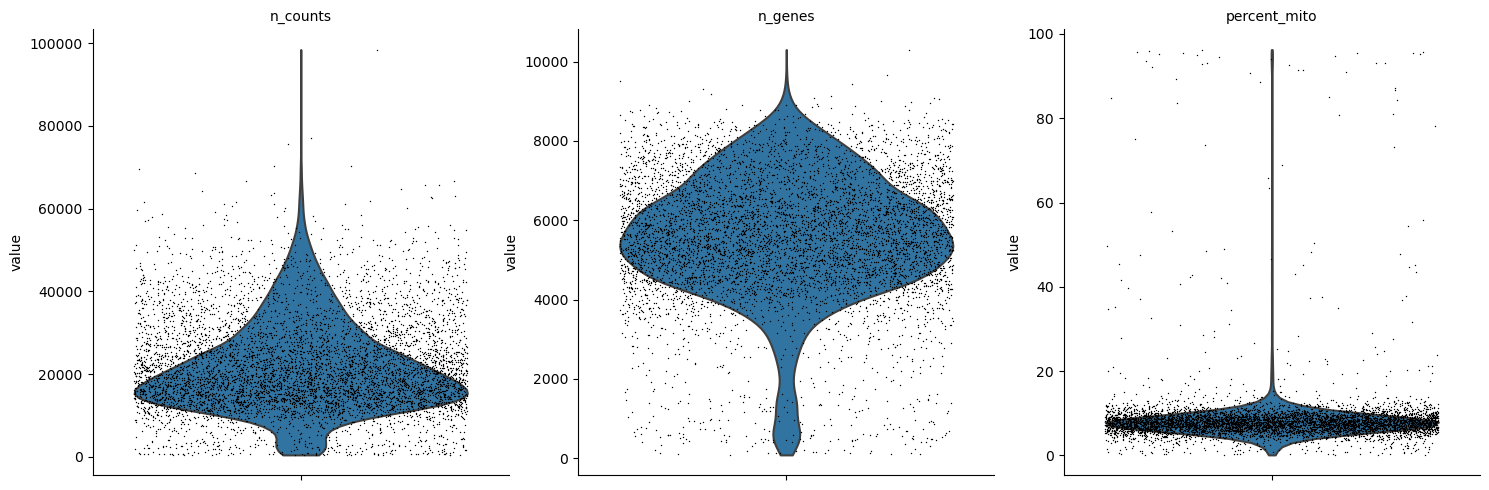

After QC


/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mzo5929/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values

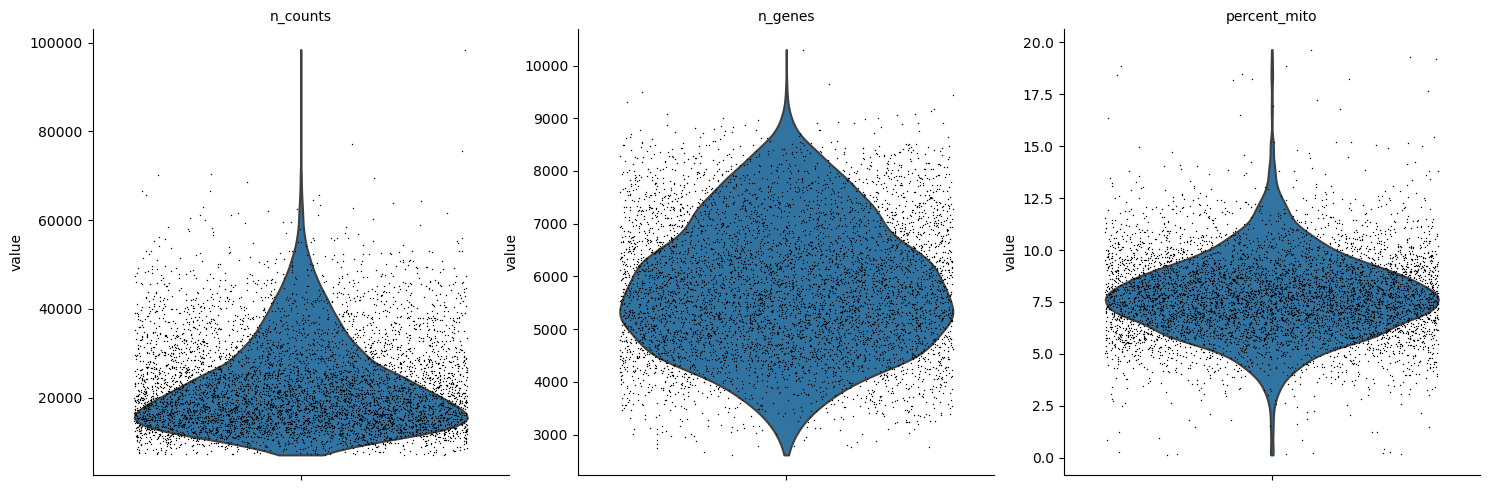

In [27]:
import matplotlib.pyplot as plt
print("Before QC")
sc.pl.violin(gem, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)
print("After QC")
sc.pl.violin(gemQC, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)
# plt.suptitle('After QC')


In [8]:
batch_labels = ['Naive', 'Gemcitabine', 'Sotorasib']

# Concatenating data with custom batch labels
adata = naiveQC.concatenate(gemQC, sotQC, batch_key='batch', batch_categories=batch_labels)
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

/tmp/ipykernel_38172/279295000.py:4: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = naiveQC.concatenate(gemQC, sotQC, batch_key='batch', batch_categories=batch_labels)


In [9]:
adata.layers["counts"] = adata.X.copy()
adata.raw = adata

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 14654 × 28503
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch'
    var: 'gene_ids', 'feature_types', 'n_counts'
    uns: 'log1p'
    layers: 'counts'

In [14]:

sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

In [13]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
model = scvi.model.SCVI(adata, gene_likelihood="nb")

In [14]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 400/400: 100%|██████████| 400/400 [11:59<00:00,  1.78s/it, v_num=1, train_loss_step=1.59e+4, train_loss_epoch=1.32e+4]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [11:59<00:00,  1.80s/it, v_num=1, train_loss_step=1.59e+4, train_loss_epoch=1.32e+4]


In [15]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [16]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

In [17]:
sc.tl.umap(adata)

In [ ]:
sc.pl.embedding(
    adata,
    basis = "umap",
    color=["batch", "leiden"],
    frameon=False,
    ncols=2,
)

In [21]:
adata.write_h5ad(filename="/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/integratedData/scviIntegrated_20240621.h5ad")

In [33]:
adata.obsp

PairwiseArrays with keys: connectivities, distances

In [22]:
import anndata as ad
adata = ad.read_h5ad("/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/integratedData/scviIntegrated_20240621.h5ad")


In [36]:
allPath = "/home/mzo5929/Keerthana/subiaHanxiaoDataAnalysis/extractedData/rdsObjects/scVIcomponents/"

In [34]:
adata

AnnData object with n_obs × n_vars = 14654 × 28503
    obs: 'n_counts', 'n_genes', 'percent_mito', 'batch', '_scvi_batch', '_scvi_labels', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_counts'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [42]:
import pandas as pd

In [48]:
# dense_matrix = adata.layers["counts"].todense()

# # Convert to DataFrame
df = pd.DataFrame(adata.obsm['X_scVI'])
df.to_csv(f'{allPath}scviEmbedding.csv', index=True, header=True)

In [47]:
adata.obsm['X_scVI'].shape
# adata.var.to_csv(f'{allPath}/features.csv')

(14654, 10)